In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
import scipy.optimize
import scipy.signal
from IPython.display import display, Math

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/fotonica04/Documentos/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles')) #Current directory


###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles/'))
spec_win.loader.exec_module(lumapi)

## Lumapi init

In [2]:
mmi = lumapi.INTERCONNECT(filename='Hybrid4x4MZI.icp')

## Calculations

In [91]:
Ng = 4.482447
LambdaC = 1.5475e-6
DeltaL = 500e-6
c = 299792458

FSR = (LambdaC**2)/(Ng*DeltaL)
display(Math('FSR = %5.3f~nm' %(FSR*1e9)))


LambdaBand = [1.5e-6, 1.6e-6]

FreqDiff = abs(c*(1/LambdaBand[0] - 1/LambdaBand[1]))
display(Math('$\Delta f = %5.3f~THz, ~~~~(%5.3f~THz~~~~--~~~~%5.3f~THz)' %(FreqDiff*1e-12,c*1e-12/LambdaBand[0],c*1e-12/LambdaBand[1])))
display(Math('$\Delta \lambda = %5.3f~nm, ~~~~(%5.3f~nm~~~~--~~~~%5.3f~nm)' %((LambdaBand[1]-LambdaBand[0])*1e9,LambdaBand[0]*1e9,LambdaBand[1]*1e9)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

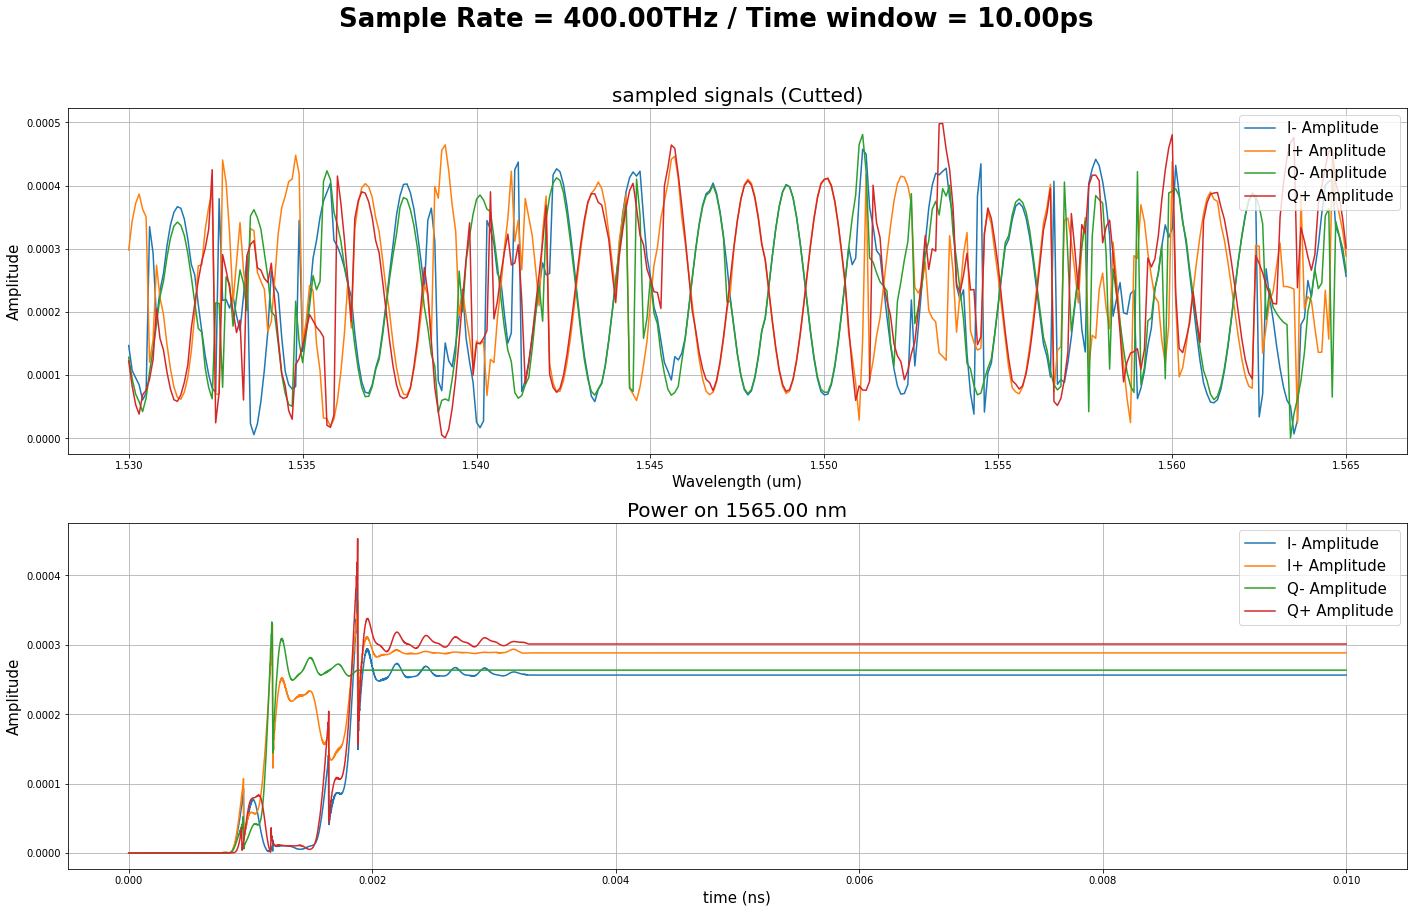

In [26]:
Cut = 150
c = 299792458

FreqArray = np.arange(1530e-9,1565e-9,0.1e-9)
AmpIN = np.zeros((len(FreqArray)))
AmpIP = np.zeros((len(FreqArray)))
AmpQN = np.zeros((len(FreqArray)))
AmpQP = np.zeros((len(FreqArray)))


for i in range(len(FreqArray)):

    mmi.switchtodesign()
    mmi.setnamed("CWL_1","frequency",c/FreqArray[i])
    mmi.run()

    Result_IN = mmi.getresult('OSC_1', 'signal')
    Result_QP = mmi.getresult('OSC_2', 'signal')
    Result_QN = mmi.getresult('OSC_3', 'signal')
    Result_IP = mmi.getresult('OSC_4', 'signal')
    Ref = mmi.getresult('OSC_5', 'signal')
    time = Result_IN['time']

    IN_sampled = Result_IN['amplitude (a.u.)']
    IP_sampled = Result_IP['amplitude (a.u.)']
    QN_sampled = Result_QN['amplitude (a.u.)']
    QP_sampled = Result_QP['amplitude (a.u.)']

    AmpIN[i] = IN_sampled[int(len(IN_sampled)/2)]
    AmpIP[i] = IP_sampled[int(len(IP_sampled)/2)]
    AmpQN[i] = QN_sampled[int(len(QN_sampled)/2)]
    AmpQP[i] = QP_sampled[int(len(QP_sampled)/2)]

SRate = mmi.get("sample rate")
TWindow = mmi.get("time window")

fig, ax= plt.subplots(2,1,figsize=(24,14))
fig.suptitle(f"Sample Rate = {SRate*1e-12:.2f}THz / Time window = {TWindow*1e12:.2f}ps", fontsize=26, fontweight='bold')
ax[0].plot(FreqArray*1e6, AmpIN, label = 'I- Amplitude')
ax[0].plot(FreqArray*1e6, AmpIP, label = 'I+ Amplitude')
ax[0].plot(FreqArray*1e6, AmpQN, label = 'Q- Amplitude')
ax[0].plot(FreqArray*1e6, AmpQP, label = 'Q+ Amplitude')
#plt.xlim([0, 1])
ax[0].grid(True)
ax[0].set_xlabel('Wavelength (um)',fontsize =15)
ax[0].set_ylabel('Amplitude',fontsize =15)
ax[0].set_title('sampled signals (Cutted)',fontsize =20)
ax[0].legend(loc = 'upper right',fontsize =15)

ax[1].plot(time*1e9, IN_sampled, label = 'I- Amplitude')
ax[1].plot(time*1e9, IP_sampled, label = 'I+ Amplitude')
ax[1].plot(time*1e9, QN_sampled, label = 'Q- Amplitude')
ax[1].plot(time*1e9, QP_sampled, label = 'Q+ Amplitude')
#plt.xlim([0, 1])
ax[1].grid(True)
ax[1].set_xlabel('time (ns)',fontsize =15)
ax[1].set_ylabel('Amplitude',fontsize =15)
ax[1].set_title(f'Power on {FreqArray[-1]*1e9:.2f} nm',fontsize =20)
ax[1].legend(loc = 'upper right',fontsize =15)

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/MZIAnalysis" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

## Phase Algorithms (Interconnect)

Port1: 32
Port2: 32
Port3: 33
Port4: 32
Wavelength1: 43
Wavelength2: 44
Wavelength3: 43
Wavelength4: 43


(1.53, 1.565)

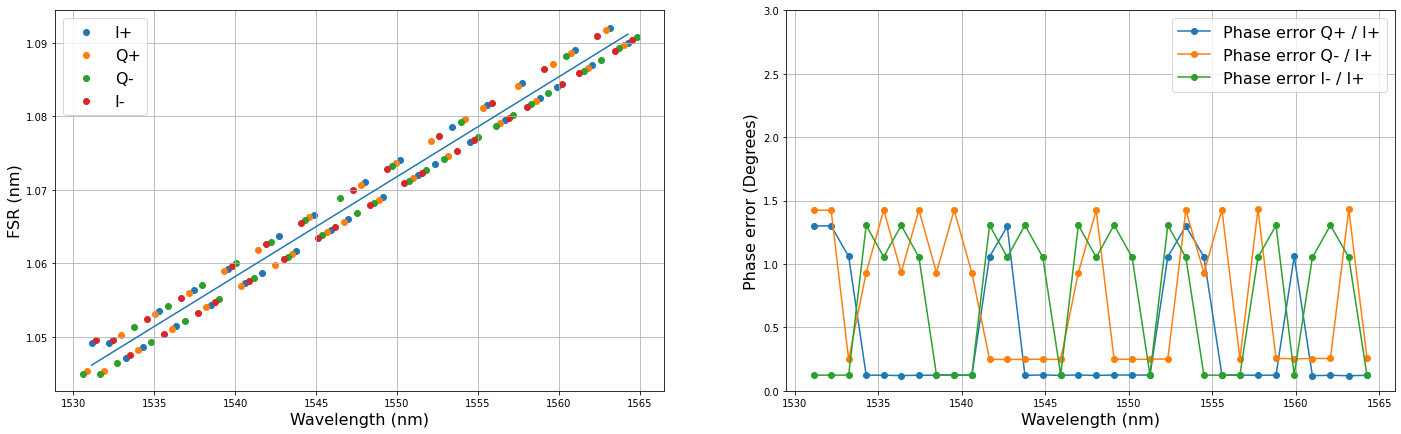

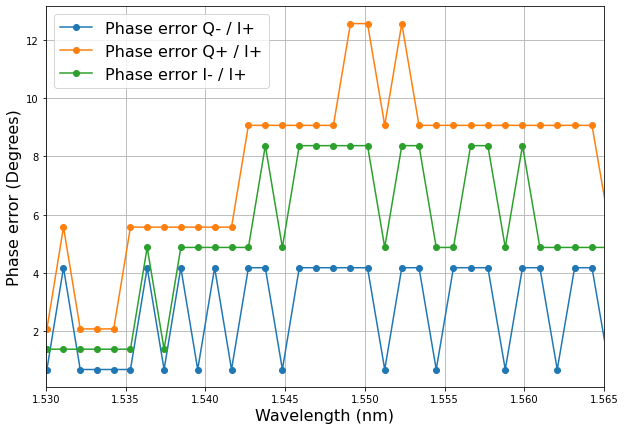

In [46]:
DataLoaded = {}
DataLoaded2 = {}
infile = open(os.path.join('SavedData', 'FSRData_500um') , 'rb')
DataLoaded = plk.load(infile)
infile.close()

infile = open(os.path.join('SavedData', 'PeaksData_500um') , 'rb')
DataLoaded2 = plk.load(infile)
infile.close()

coefs = np.polyfit(DataLoaded['Wavelength1']*1e6,DataLoaded['Port1']*1e9,1)
def f(x):
    return coefs[0]*x+coefs[1]

fig, ax= plt.subplots(1,2,figsize=(24,7))
ax[0].scatter(DataLoaded['Wavelength1']*1e6,DataLoaded['Port1']*1e9, label='I+')
ax[0].scatter(DataLoaded['Wavelength2']*1e6,DataLoaded['Port2']*1e9, label='Q+')
ax[0].scatter(DataLoaded['Wavelength3']*1e6,DataLoaded['Port3']*1e9, label='Q-')
ax[0].scatter(DataLoaded['Wavelength4']*1e6,DataLoaded['Port4']*1e9, label='I-')
ax[0].plot(DataLoaded['Wavelength1']*1e6,f(DataLoaded['Wavelength1']*1e6))
ax[0].set_xlabel('Wavelength (nm)', fontsize=16)
ax[0].set_ylabel('FSR (nm)', fontsize=16)
ax[0].grid(True)
ax[0].legend(fontsize=16)

print('Port1: ' + str(len(DataLoaded['Port1'])))
print('Port2: ' + str(len(DataLoaded['Port2'])))
print('Port3: ' + str(len(DataLoaded['Port3'])))
print('Port4: ' + str(len(DataLoaded['Port4'])))

ax[1].plot(DataLoaded['Wavelength1']*1e6,abs(DataLoaded['Port2']/DataLoaded['Port1'] - 1)*360, '-o' ,label='Phase error Q+ / I+')
ax[1].plot(DataLoaded['Wavelength1']*1e6,abs(DataLoaded['Port3'][:-1]/DataLoaded['Port1'] - 1)*360, '-o' , label='Phase error Q- / I+')
ax[1].plot(DataLoaded['Wavelength1']*1e6,abs(DataLoaded['Port4']/DataLoaded['Port1'] - 1)*360, '-o' , label='Phase error I- / I+')
ax[1].set_xlabel('Wavelength (nm)', fontsize=16)
ax[1].set_ylabel('Phase error (Degrees)', fontsize=16)
ax[1].set_ylim(0,3)
ax[1].grid(True)
ax[1].legend(fontsize=16)

print('Wavelength1: ' + str(len(DataLoaded2['Wavelength1'])))
print('Wavelength2: ' + str(len(DataLoaded2['Wavelength2'])))
print('Wavelength3: ' + str(len(DataLoaded2['Wavelength3'])))
print('Wavelength4: ' + str(len(DataLoaded2['Wavelength4'])))

DifQ2 = 1e9*abs(DataLoaded2['Wavelength1']-DataLoaded2['Wavelength2'][:-1])/f(DataLoaded2['Wavelength2'][:-1])
DifQ1 = 1e9*abs(DataLoaded2['Wavelength3']-DataLoaded2['Wavelength2'][:-1])/f(DataLoaded2['Wavelength2'][:-1])
DifI2 = 1e9*abs(DataLoaded2['Wavelength4']-DataLoaded2['Wavelength2'][:-1])/f(DataLoaded2['Wavelength2'][:-1])

plt.figure(figsize=(10,7))
plt.plot(DataLoaded2['Wavelength2'][:-1]*1e6,abs(90-abs(DifQ2*360)), '-o' ,label='Phase error Q- / I+')
plt.plot(DataLoaded2['Wavelength2'][:-1]*1e6,abs(270-abs(DifQ1*360)), '-o' ,label='Phase error Q+ / I+')
plt.plot(DataLoaded2['Wavelength2'][:-1]*1e6,abs(180-abs(DifI2*360)), '-o' ,label='Phase error I- / I+')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Phase error (Degrees)', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.xlim(1.53,1.565)

Center Wavelength: 1.5550000000000001e-06, Limits: 1.5272327950913587e-06/1.5827672049086416e-06


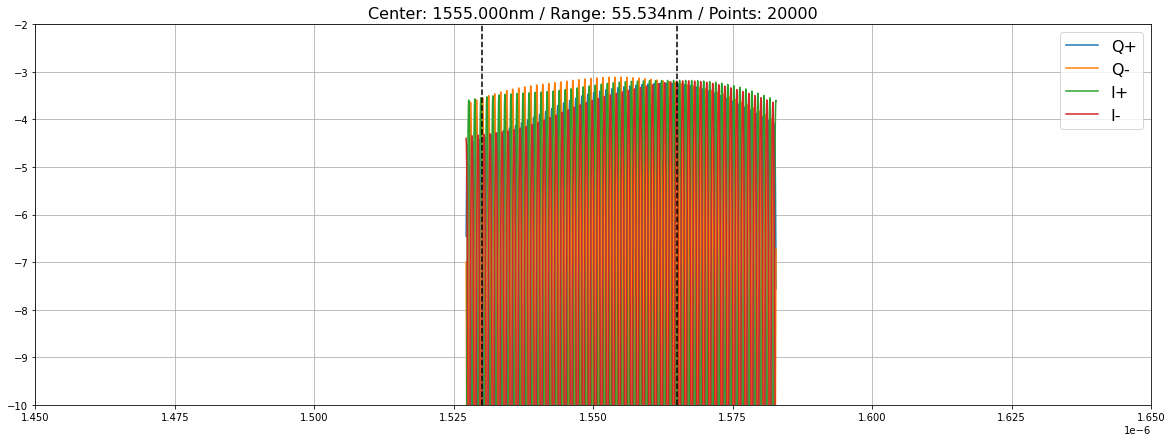

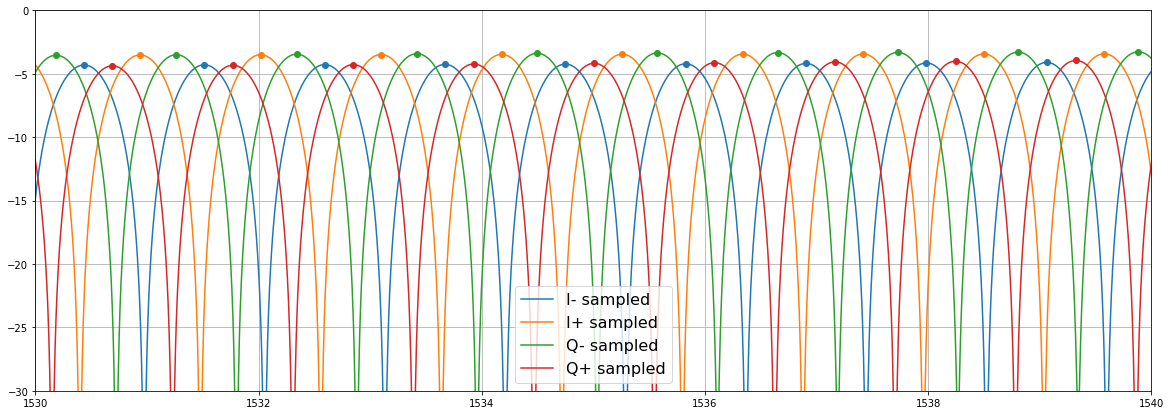

In [120]:
c = 299792458
mmi.select('ONA_2')
CenterWv = c/mmi.get('center frequency')
RangeWv = mmi.get('frequency range')*CenterWv**2/c

Res_QP = np.array(mmi.getresultdata('ONA_2','input 1/mode 1/gain')[:,0])
Res_IP = np.array(mmi.getresultdata('ONA_2','input 2/mode 1/gain')[:,0])
Res_QN = np.array(mmi.getresultdata('ONA_2','input 3/mode 1/gain')[:,0])
Res_IN = np.array(mmi.getresultdata('ONA_2','input 4/mode 1/gain')[:,0])
Xarray = np.linspace(CenterWv-RangeWv/2,CenterWv+RangeWv/2,20000)
print(f'Center Wavelength: {CenterWv}, Limits: {CenterWv-RangeWv/2}/{CenterWv+RangeWv/2}')
plt.figure(figsize=(20,7))
plt.title(f'Center: {CenterWv*1e9:.3f}nm / Range: {RangeWv*1e9:.3f}nm / Points: {len(Xarray)}', fontsize=16)
plt.plot(Xarray,Res_QP, label='Q+')
plt.plot(Xarray,Res_QN, label='Q-')
plt.plot(Xarray,Res_IP, label='I+')
plt.plot(Xarray,Res_IN, label='I-')
plt.axvline(x = 1530e-9, linestyle='--',color = 'black')
plt.axvline(x = 1565e-9, linestyle='--',color = 'black')
plt.xlim(1450e-9,1650e-9)
#plt.xlim(1530e-9,1565e-9)
plt.ylim(-10,-2)
plt.grid()
plt.legend(fontsize=16)

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/ONA_Analysis" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

INps, _ = scipy.signal.find_peaks(Res_IN) # Receiving peaks array and ignoring matrix information elements
IPps, _ = scipy.signal.find_peaks(Res_IP) # Receiving peaks array and ignoring matrix information elements
QNps, _ = scipy.signal.find_peaks(Res_QN) # Receiving peaks array and ignoring matrix information elements
QPps, _ = scipy.signal.find_peaks(Res_QP) # Receiving peaks array and ignoring matrix information elements
INpeaks = Xarray[INps]
IPpeaks = Xarray[IPps]
QNpeaks = Xarray[QNps]
QPpeaks = Xarray[QPps]

plt.figure(figsize=(20,7))
plt.plot(INpeaks*1e9, Res_IN[INps] ,"o", color="#1f77b4")
plt.plot(Xarray*1e9, Res_IN, label = 'I- sampled', color="#1f77b4")
plt.plot(IPpeaks*1e9, Res_IP[IPps] ,"o", color="#ff7f0e")
plt.plot(Xarray*1e9, Res_IP, label = 'I+ sampled', color="#ff7f0e")
plt.plot(QNpeaks*1e9, Res_QN[QNps] ,"o", color="#2ca02c")
plt.plot(Xarray*1e9, Res_QN, label = 'Q- sampled', color="#2ca02c")
plt.plot(QPpeaks*1e9, Res_QP[QPps] ,"o", color="#d62728")
plt.plot(Xarray*1e9, Res_QP, label = 'Q+ sampled', color="#d62728")
plt.xlim(1530,1540)
plt.ylim(-30,0)
plt.grid()
plt.legend(fontsize=16)

QNPeaks: 51
QPPeaks: 52
INPeaks: 51
IPPeaks: 52
1.0793482218804495e-09


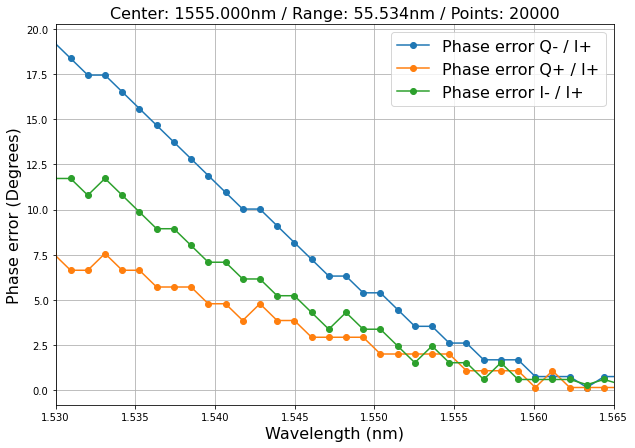

In [121]:
print('QNPeaks: ' + str(len(QNpeaks)))
print('QPPeaks: ' + str(len(QPpeaks)))
print('INPeaks: ' + str(len(INpeaks)))
print('IPPeaks: ' + str(len(IPpeaks)))

DistI1 = IPpeaks[:-2]
DistI1 = np.append(DistI1,[1])
DistAvg = np.average(DistI1[1:-1]-IPpeaks[:-3])
print(DistAvg)

DifQ2 = abs(QNpeaks[:-1]-IPpeaks[:-2])/DistAvg
DifQ1 = abs(QPpeaks[:-2]-IPpeaks[:-2])/DistAvg
DifI2 = abs(INpeaks[:-1]-IPpeaks[:-2])/DistAvg

plt.figure(figsize=(10,7))
plt.plot(IPpeaks[:-2]*1e6, abs(90-abs(DifQ2*360)), '-o' ,label='Phase error Q- / I+')
plt.plot(IPpeaks[:-2]*1e6, abs(90-abs(DifQ1*360)), '-o' ,label='Phase error Q+ / I+')
plt.plot(IPpeaks[:-2]*1e6, abs(180-abs(DifI2*360)), '-o' ,label='Phase error I- / I+')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Phase error (Degrees)', fontsize=16)
plt.title(f'Center: {CenterWv*1e9:.3f}nm / Range: {RangeWv*1e9:.3f}nm / Points: {len(Xarray)}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.xlim(1.53,1.565)
#plt.ylim(0,10)

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/PhaseError_FSR" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

# plt.figure(figsize=(10,7))
# plt.plot(np.linspace(0,1,len(DistI1[1:-1])),(DistI1[1:-1]-IPpeaks[:-3])*1e9)

50
50
50


(0.0, 4.0)

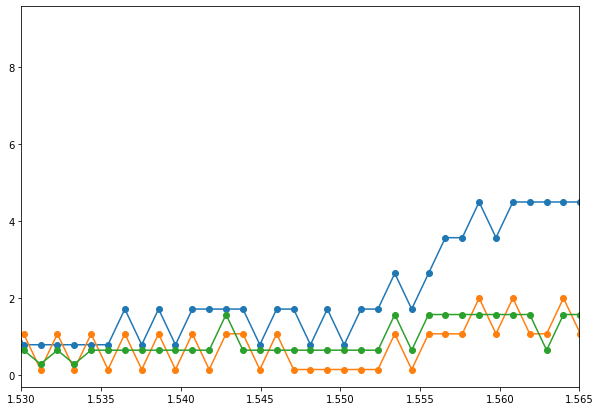

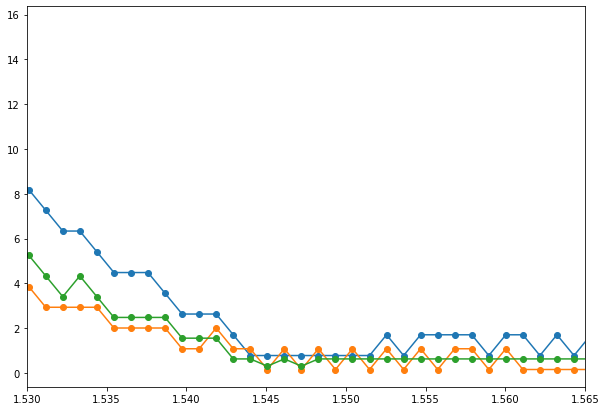

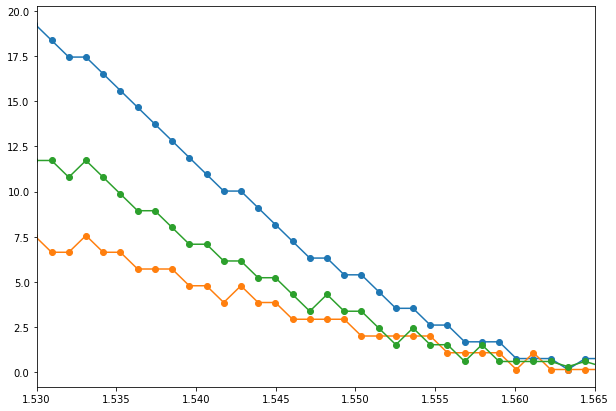

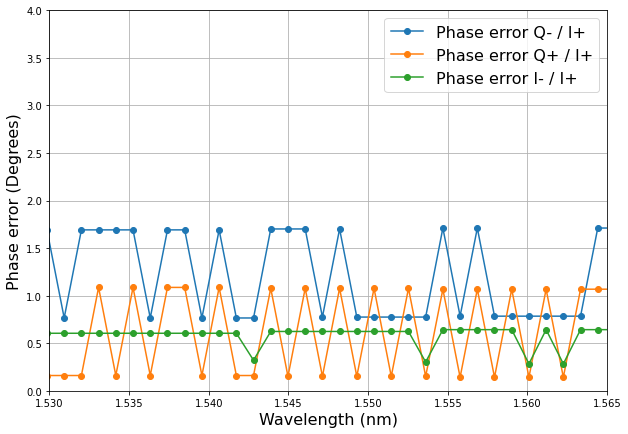

In [133]:
Array3A = abs(90-abs(DifQ2*360))
Array3B = abs(90-abs(DifQ1*360))
Array3C = abs(180-abs(DifI2*360))
Array3D = IPpeaks[:-2]*1e6

plt.figure(figsize=(10,7))
plt.plot(Array1D, Array1A, '-o' ,label='Phase error Q- / I+')
plt.plot(Array1D, Array1B, '-o' ,label='Phase error Q+ / I+')
plt.plot(Array1D, Array1C, '-o' ,label='Phase error I- / I+')
plt.xlim(1.53,1.565)

plt.figure(figsize=(10,7))
plt.plot(Array2D, Array2A, '-o' ,label='Phase error Q- / I+')
plt.plot(Array2D, Array2B, '-o' ,label='Phase error Q+ / I+')
plt.plot(Array2D, Array2C, '-o' ,label='Phase error I- / I+')
plt.xlim(1.53,1.565)

plt.figure(figsize=(10,7))
plt.plot(Array3D, Array3A, '-o' ,label='Phase error Q- / I+')
plt.plot(Array3D, Array3B, '-o' ,label='Phase error Q+ / I+')
plt.plot(Array3D, Array3C, '-o' ,label='Phase error I- / I+')
plt.xlim(1.53,1.565)

print(len(Array1D))
print(len(Array2D))
print(len(Array3D))

Array4A = np.concatenate([Array1A[:25],Array2A[25:35],Array3A[35:]])
Array4B = np.concatenate([Array1B[:25],Array2B[25:35],Array3B[35:]])
Array4C = np.concatenate([Array1C[:25],Array2C[25:35],Array3C[35:]])

plt.figure(figsize=(10,7))
plt.plot(Array3D, Array4A[::-1], '-o' ,label='Phase error Q- / I+')
plt.plot(Array3D, Array4B[::-1], '-o' ,label='Phase error Q+ / I+')
plt.plot(Array3D, Array4C[::-1], '-o' ,label='Phase error I- / I+')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Phase error (Degrees)', fontsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.xlim(1.53,1.565)
plt.ylim(0,4)